In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Sequence, Any
from deepmeg.preprocessing.transforms import one_hot_encoder, zscore
from deepmeg.data.datasets import EpochsDataset
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchmetrics
from deepmeg.training.callbacks import EarlyStopping, PrintingCallback, L2Reg
from deepmeg.utils.viz import plot_metrics
from functools import partial
from deepmeg.utils.convtools import compute_output_shape, conviter
import torch.nn.init as init
import math


def plot_2d_projections(matrix: np.ndarray, cmap=None) -> plt.Figure:
    """
    Plot the mean projections of a 3D matrix along the X, Y, and Z axes.

    Args:
        matrix (np.ndarray): A 3D matrix to plot.

    Returns:
        plt.Figure: A matplotlib Figure object containing the 2D projections along the X, Y, and Z axes.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(matrix.mean(axis=0), cmap=cmap)
    ax2.imshow(matrix.mean(axis=1), cmap=cmap)
    ax3.imshow(matrix.mean(axis=2), cmap=cmap)
    return fig


class ConvBlock(nn.Module):
    '''A module that implements a repetitive block of convolutional layer, batch normalization, nonlinearity, and dropout.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        kernel_size (Union[int, Tuple[int, int, int]]): Size of the convolutional kernel. If a single integer is given, the kernel will have the same size in all dimensions.
        stride (Union[int, Tuple[int, int, int]]): Stride of the convolution. If a single integer is given, the stride will be the same in all dimensions. Default: 1
        padding (Union[int, Tuple[int, int, int]]): Zero-padding added to all three sides of the input. If a single integer is given, the padding will be the same in all dimensions. Default: 0
        dilation (Union[int, Tuple[int, int, int]]): Spacing between kernel elements. If a single integer is given, the dilation will be the same in all dimensions. Default: 1
        drop (float): Dropout probability. Default: 0.0
        nonlinearity (nn.Module): Nonlinearity applied after batch normalization. Default: nn.ReLU()

    Attributes:
        conv (nn.Conv3d): Convolutional layer.
        bn (nn.BatchNorm3d): Batch normalization layer.
        nonlin (nn.Module): Nonlinearity applied after batch normalization.
        drop (nn.Dropout): Dropout layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor: Performs forward pass through the module.

    Returns:
        torch.Tensor: Tensor of shape (N, C, D_out, H_out, W_out) representing the output of the module.
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, drop=0.0, nonlinearity=nn.ReLU()):
        super().__init__()
        self.conv = nn.Conv3d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation
        )
        self.bn = nn.BatchNorm3d(out_channels)
        self.nonlin = nonlinearity
        self.drop = nn.Dropout(p=drop)

    def forward(self,x):
        '''Performs forward pass through the module.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, D_in, H_in, W_in).

        Returns:
            torch.Tensor: Output tensor of shape (N, C, D_out, H_out, W_out).
        '''
        x = self.conv(x)
        x = self.bn(x)
        return self.drop(self.nonlin(x))


def compute_kernel_side(
    original_side: int,
    convolved_side: int,
    stride: int = 1,
    padding: int = 0,
    dilration: int = 1
):
    """
    Compute the size of a kernel for a given convolutional layer based on its input and output size and other parameters.

    Args:
    original_side (int): The size of the input along one dimension (e.g., height or width).
    convolved_side (int): The size of the output of the convolutional layer along the same dimension.
    stride (int): The stride of the convolutional layer (default: 1).
    padding (int): The padding size of the convolutional layer (default: 0).
    dilration (int): The dilation of the convolutional layer (default: 1).

    Returns:
    int: The size of the kernel for the convolutional layer along the given dimension.
    """
    return int((original_side + 2*padding - 1 - stride*(convolved_side - 1))/dilration + 1)

def compute_out_side(
    original_side: int,
    kernel_side: int,
    stride: int = 1,
    padding: int = 0,
    dilration: int = 1
):
    """
    Computes the output size of a convolution layer given its input size, kernel size, stride, padding, and dilation.

    Args:
        original_side (int): The size of the input feature map.
        kernel_side (int): The size of the convolution kernel.
        stride (int, optional): The stride of the convolution operation. Defaults to 1.
        padding (int, optional): The padding of the convolution operation. Defaults to 0.
        dilation (int, optional): The dilation rate of the convolution operation. Defaults to 1.

    Returns:
        int: The size of the output feature map after applying the convolution operation.
    """
    return int((original_side + 2*padding - dilration*(kernel_side - 1) - 1)/stride + 1)


class VGG3D(BaseModel):
    """
    A 3D version of the VGG neural network architecture. Each convolution reduces each dimension by half.

    Parameters:
        shape (int): The size of the input tensor in the form of (z, y, x).
        n_conv_blocks (int): The number of convolutional blocks.
        max_pool_size (tuple[int, int, int]): The size of the max pooling kernel in the form of (z, y, x).
        n_fc_layers (int): The number of fully connected layers.
        n_classes (int): The number of output classes.
        convblocks_kwargs (dict): Optional arguments to pass to each ConvBlock instance.

    Raises:
        ValueError: If the size of any plane in the shape is reduced to 0 by the convolutional layers.

    Attributes:
        conv_blocks (nn.ModuleList): A list of ConvBlock instances.
        max_pool (nn.MaxPool3d): A 3D max pooling layer.
        fc_layers (nn.ModuleList): A list of fully connected layers.
        num_features (int): The total number of features in the final convolutional layer.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Computes the forward pass of the network.

    """
    def __init__(
        self,
        shape: int,
        n_conv_blocks: int,
        max_pool_size: tuple[int, int, int],
        n_fc_layers: int,
        n_classes: int,
        convblocks_kwargs: dict = None,
    ):
        super().__init__()

        if convblocks_kwargs is None:
            convblocks_kwargs = dict()

        self.conv_blocks = nn.ModuleList()
        self.max_pool = nn.MaxPool3d(max_pool_size, max_pool_size)
        self.fc_layers = nn.ModuleList()

        for _ in range(n_conv_blocks):

            self.conv_blocks.append(
                ConvBlock(
                    1, 1,
                    kernel_size=[compute_kernel_side(plane, plane//2) for plane in shape],
                    **convblocks_kwargs
                )
            )
            shape = [plane//2 for plane in shape]
            shape = [
                compute_out_side(plane, mp, mp)
                for plane, mp in zip(shape, max_pool_size)
            ]

            if any([plane == 0 for plane  in shape]):
                raise ValueError('Convolutional layers have reduced the input to 0')

        self.num_features = np.prod(shape)

        for i in range(n_fc_layers):
            if i != n_fc_layers - 1:
                self.fc_layers.append(
                    nn.Linear(self.num_features, self.num_features)
                )
            else:
                self.fc_layers.append(
                    nn.Linear(self.num_features, n_classes)
                )


    def forward(self, x: torch.Tensor):
        """
        Forward pass of the VGG3D model.

        Args:
            x (torch.Tensor): Input tensor of shape `(batch_size, channels, depth, height, width)`.

        Returns:
            torch.Tensor: Output tensor of shape `(batch_size, num_classes)`.
        """
        x = torch.unsqueeze(x, 1)

        for conv_block in self.conv_blocks:
            x = conv_block(x)
            x = self.max_pool(x)

        x = torch.flatten(x, start_dim=1)

        for fc_layer in self.fc_layers:
            x = fc_layer(x)

        return x


import numpy as np

def pad_matrix(matrix):
    """
    Pad a matrix with zeros to match the largest side.

    Args:
    - matrix: A numpy array representing the input matrix.

    Returns:
    - padded_matrix: A numpy array with the padded matrix.
    """

    max_side = max(matrix.shape)
    pad_widths = [(0, max_side - dim) for dim in matrix.shape]
    padded_matrix = np.pad(matrix, pad_widths, mode='constant')

    return padded_matrix


class ResConv3D(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
    ):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.kernel_size = kernel_size
        self.input_size = input_size
        self.stride = stride
        self.padding = padding
        self.wave1 = nn.Parameter(torch.empty(self.in_channels, self.kernel_size[0], self.input_size[1], self.input_size[2], self.out_channels))
        self.wave2 = nn.Parameter(torch.empty(self.in_channels, self.input_size[0], self.kernel_size[1], self.input_size[2], self.out_channels))
        self.wave3 = nn.Parameter(torch.empty(self.in_channels, self.input_size[0], self.input_size[1], self.kernel_size[2], self.out_channels))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Reset the layer parameters.
        Uses the Kaiming initialization method for the weight matrix and a uniform initialization method for the bias vector.
        """
        init.kaiming_uniform_(self.wave1, a=math.sqrt(5))
        init.kaiming_uniform_(self.wave2, a=math.sqrt(5))
        init.kaiming_uniform_(self.wave3, a=math.sqrt(5))

        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.wave1)

            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)


    def forward(self, x):
        convargs = ((x.shape[-3], x.shape[-2], x.shape[-1]), self.kernel_size, self.padding, self.stride)
        # print(convargs) # ((34, 43, 34), (10, 10, 10), 0, 'same')
        out_shape = compute_output_shape(*convargs)
        out_tensor = torch.zeros(x.shape[0], self.out_channels, *out_shape)
        b = self.bias if self.bias is not None else [0 for _ in range(self.out_channels)]

        for n_neuron in range(self.out_channels):
            for p, q, k in conviter(*convargs):
                x_slice = x[:, :, p[0], p[1], p[2]]
                w1_slice = self.wave1[:, k[0], p[1], p[2], n_neuron]
                w2_slice = self.wave2[:, p[0], k[1], p[2], n_neuron]
                w3_slice = self.wave3[:, p[0], p[1], k[2], n_neuron]
                # res = torch.unsqueeze(torch.unsqueeze((w1_slice*w2_slice*x_slice).sum((1, 2, 3)), -1), -1)
                # res = torch.unsqueeze(torch.unsqueeze(((w1_slice+w2_slice)*x_slice).sum((1, 2, 3)), -1), -1)
                # print(w1_slice.shape, w2_slice.shape, w3_slice.shape, x_slice.shape)
                res = ((w1_slice + w2_slice + w3_slice)*x_slice).sum((1, 2, 3, 4)) + b[n_neuron]
                # res = ((w1_slice + w2_slice)*x_slice).sum((1, 2, 3))
                # print(torch.squeeze(res).item(),w1_slice.item(), w2_slice.item(), x_slice.item())
                # print(out_tensor[:, n_neuron, q[-2], q[-1]].shape, res.shape)
                out_tensor[:, n_neuron, q[-3], q[-2], q[-1]] = res

        return out_tensor


class CC2(BaseModel):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        maxpool_size,
        n_classes: int,
        stride=1,
        padding=0,
        dropout=None
    ):
        super().__init__()
        self.n_classes = n_classes
        self.rc = ResConv3D(in_channels, out_channels, input_size, kernel_size, stride, padding)
        self.dp = None if dropout is None else nn.Dropout(dropout)
        self.relu = nn.ReLU()
        convargs = (input_size, kernel_size, padding, stride)
        self.convout_shape = compute_output_shape(*convargs)
        self.maxpool = nn.MaxPool3d((maxpool_size, maxpool_size, maxpool_size), maxpool_size)
        convargs = (self.convout_shape, (maxpool_size, maxpool_size, maxpool_size), 0, maxpool_size)
        self.maxpool_shape = compute_output_shape(*convargs)
        self.num_features = out_channels*np.prod(self.maxpool_shape)
        self.linear = nn.Linear(self.num_features, self.n_classes)


    def forward(self, x: torch.Tensor):
        x = torch.unsqueeze(x, 1)

        x = self.rc(x)
        if self.dp:
            x = self.dp(x)
        # x = self.relu(x)
        x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

/data/pt_02648/deepmeg/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
import os
import warnings
warnings.filterwarnings(action='once')

from nilearn import datasets
import nibabel as nb
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# mask the data

ni_img_orig = nb.load(func_file)

X = np.transpose(np.array(ni_img_orig.dataobj), (3, 0, 1, 2))

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
Y = behavioral['labels']

label_dict = {value: key for key, value in dict(enumerate(np.unique(Y))).items()}


Y = [label_dict[sample] for sample in Y.to_list()]
Y = one_hot_encoder(np.array(Y))

In [13]:
np.array(nb.load(func_file).dataobj).shape

(40, 64, 64, 1452)

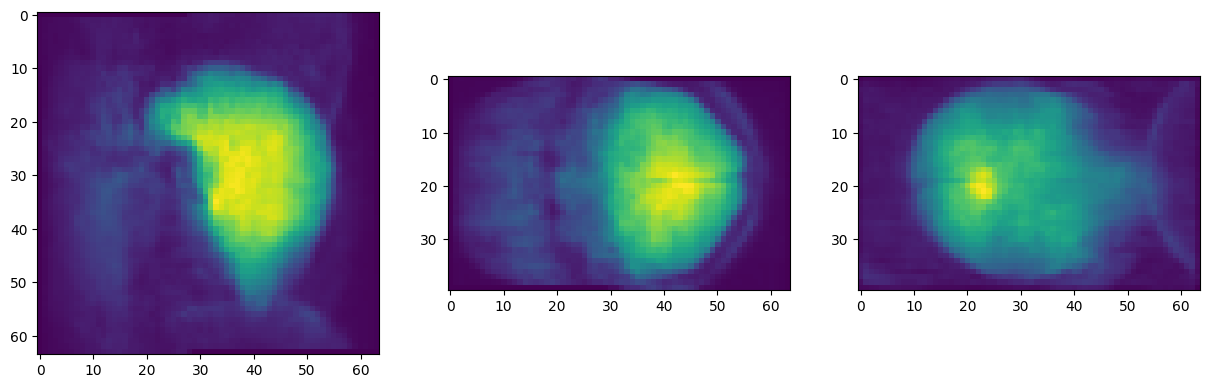

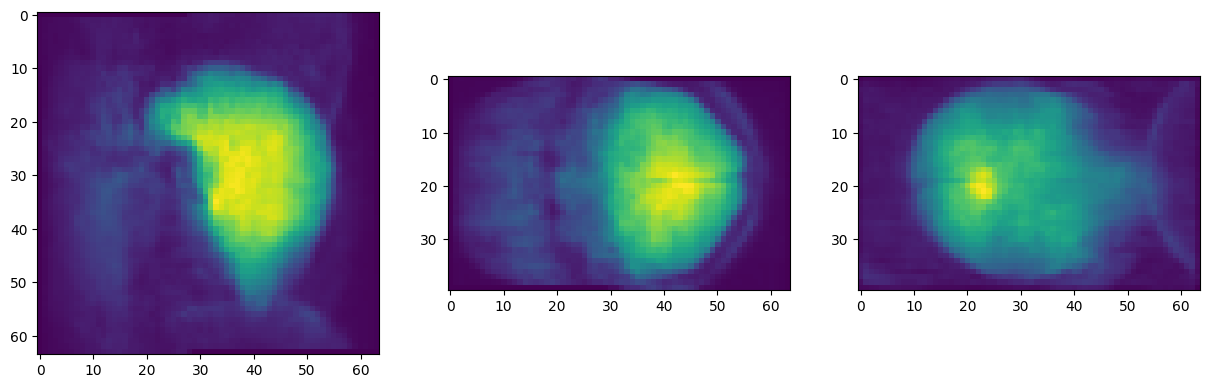

In [26]:
plot_2d_projections(X[0])

In [27]:
from deepmeg.utils.colors import generate_cmap

cmap = generate_cmap(*[
    '#003535',
    '#00b2b2',
    # '#00ffff',
    # '#fff',
    '#b20000'
])

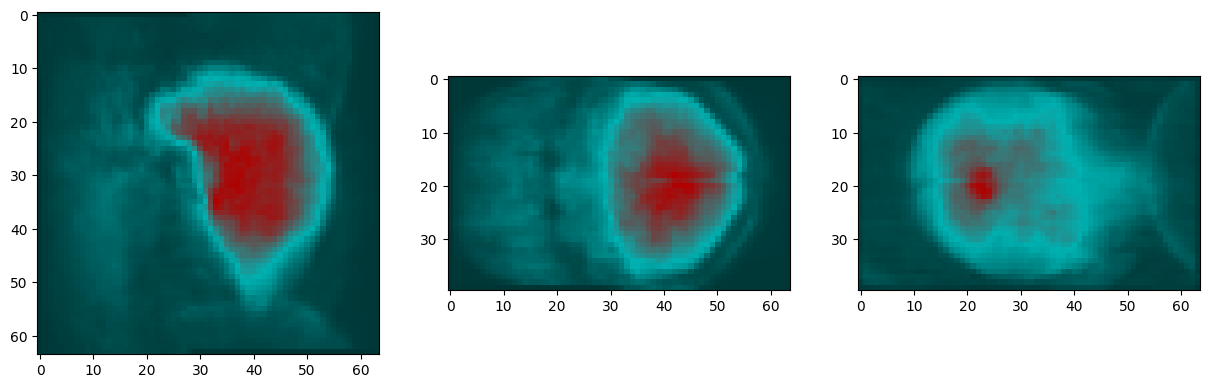

In [29]:
fig = plot_2d_projections(X[0], cmap=cmap)

In [60]:
X = [x[crop_params[0][0]:crop_params[0][1], crop_params[1][0]:crop_params[1][1], crop_params[2][0]:crop_params[2][1]] for x in X]

In [51]:
X[0].shape

(79, 93, 71)

In [52]:
X[0].min()

-4.173944594459315

In [30]:
dataset = EpochsDataset((X, Y), savepath='../datasets/fmri_haxby',
                        transform=zscore
)
dataset.save('../data/fmri_haxby.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [4]:
dataset = EpochsDataset.load('../data/fmri_haxby.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

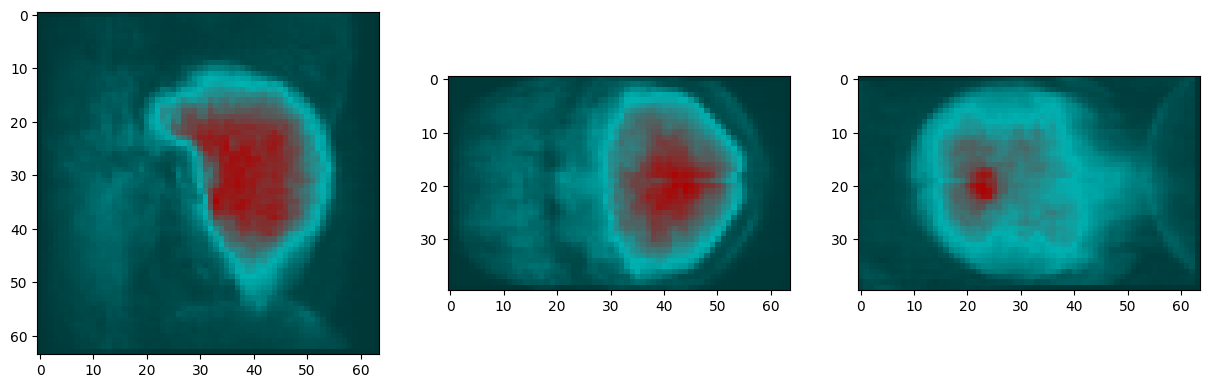

In [31]:
fig = plot_2d_projections(train[np.random.randint(0, len(train))][0], cmap=cmap)

In [32]:
class CC2(BaseModel):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        maxpool_size,
        n_classes: int,
        stride=1,
        padding=0,
        dropout=None,
        batchnorm=False
    ):
        super().__init__()
        self.n_classes = n_classes
        self.rc = ResConv3D(in_channels, out_channels, input_size, kernel_size, stride, padding)
        self.dp = None if dropout is None else nn.Dropout(dropout)
        self.bn = nn.BatchNorm3d(out_channels) if batchnorm else None
        convargs = (input_size, kernel_size, padding, stride)
        self.convout_shape = compute_output_shape(*convargs)
        self.maxpool = nn.MaxPool3d((maxpool_size, maxpool_size, maxpool_size), maxpool_size)
        convargs = (self.convout_shape, (maxpool_size, maxpool_size, maxpool_size), 0, maxpool_size)
        self.maxpool_shape = compute_output_shape(*convargs)
        self.num_features = out_channels*np.prod(self.maxpool_shape)
        self.linear = nn.Linear(self.num_features, self.n_classes)


    def forward(self, x: torch.Tensor):
        x = torch.unsqueeze(x, 1)
        # if self.bn:
        #     x = self.bn(x)
        x = self.rc(x)
        if self.dp:
            x = self.dp(x)
        if self.bn:
            x = self.bn(x)
        # x = self.relu(x)
        x = self.maxpool(x)
        # if self.bn:
        #     x = self.bn(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

In [102]:
X.shape

torch.Size([10, 79, 93, 71])

In [243]:
model.state_dict().keys()

odict_keys(['rc.wave1', 'rc.wave2', 'rc.wave3', 'rc.bias', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked', 'linear.weight', 'linear.bias'])

In [33]:

X, Y = next(iter(DataLoader(train, 10)))
X.shape, Y.shape

(torch.Size([10, 40, 64, 64]), torch.Size([10, 9]))

In [34]:
def accuracy(predictions, targets):

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy

In [97]:
model = CC2(
    in_channels=1,
    out_channels=2,
    input_size=X[0].shape,
    kernel_size=(10, 10, 10),
    maxpool_size=5,
    n_classes=Y.shape[-1],
    stride=5,
    dropout=.4,
    batchnorm=False
)

optimizer = torch.optim.Adam#W(model.parameters(), lr=1e-3, weight_decay=0.0001)

# optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.0001)
loss = torch.nn.BCEWithLogitsLoss()
metric = ('accuracy', accuracy)

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        L2Reg(
            [
                'rc.wave1', 'rc.wave2', 'rc.wave3'
            ],
            0.01
        ),
        EarlyStopping(monitor='loss_val', restore_best_weights=True, patience=5)
    ]
)

In [98]:
model.convout_shape, model.maxpool_shape, model.num_features

((7, 11, 11), (1, 2, 2), 8)

In [99]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [100]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

Epoch 0:  loss_train:  0.5579   |    accuracy_train:  0.0665   |    loss_val:  0.4282   |    accuracy_val:  0.1032
Epoch 1:  loss_train:  0.4471   |    accuracy_train:  0.0728   |    loss_val:  0.4134   |    accuracy_val:  0.1032
Epoch 2:  loss_train:  0.4340   |    accuracy_train:  0.0728   |    loss_val:  0.4037   |    accuracy_val:  0.3051
Epoch 3:  loss_train:  0.4212   |    accuracy_train:  0.0741   |    loss_val:  0.4014   |    accuracy_val:  0.3704
  3%|▎         | 4/150 [01:00<37:03, 15.23s/it]


KeyboardInterrupt: 

In [90]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3810066662051461
train_accuracy: 0.37302301824092865
loss: 0.3716490729288621
accuracy: 0.4274841465733268


In [ ]:
from pytorch_metric_learning.samplers import MPerClassSampler
from deepmeg.preprocessing.transforms import one_hot_decoder


X, Y = next(iter(DataLoader(train, len(train))))
train_loader = DataLoader(train, batch_size=192, sampler = MPerClassSampler(one_hot_decoder(Y.numpy()), 8))

X, Y = next(iter(DataLoader(test, len(test))))
val_loader = DataLoader(test, batch_size=72, sampler = MPerClassSampler(one_hot_decoder(Y.numpy()), 8))

history = model.fit(train_loader, val_data=val_loader, n_epochs=150)
plot_metrics(history)

In [202]:
from deepmeg.preprocessing.transforms import one_hot_decoder
a = test
X, Y = next(iter(DataLoader(a, len(a))))
Y_pred = model(X).detach()
print(one_hot_decoder(Y_pred))

[ 7 11  2  4  9 10  7 10 11  5 10  6 11  4  9  4  7  3  1  3  3  9  4 10
  9  3 11  0  3 10  2  0  0  6  4  4  3  3  4  1 11  6  3 11 11  4 11 11
  3 11 10  3 11 11 10  6  4  3 10  9  7 11  2  9 11  7  3  6  4  4  3  4
  5  4  4 10 10 10 11  2  3  7  7 11  0 11  7  7 11  4  4  3  7 11  6  3
  2 10  2  4  3  4  4  7  3  7  0  5 10  0  3  8  9  7  3  0 11  4  4 10
  3  4  6  7  4  5 10  9 11  4  9 10 10  3  3 11  2  4  7  4  4 10  3 11
 10 11  6 10 11 11 11  9  3  1  4  3 10 11  8  4  5  4 11 10 11  0 11  3
  4  7  4  4  7  7  9  7  7  3  4  6 11  7  9 10 11 11 11  9 11  3  5 11
  0  9  7  3  4 10 10]


In [203]:
for y, p in zip(one_hot_decoder(Y), one_hot_decoder(Y_pred)):
    print(y, '\t', p)

9 	 7
3 	 11
1 	 2
7 	 4
1 	 9
10 	 10
7 	 7
3 	 10
4 	 11
9 	 5
2 	 10
4 	 6
6 	 11
9 	 4
9 	 9
9 	 4
4 	 7
9 	 3
10 	 1
6 	 3
1 	 3
7 	 9
3 	 4
0 	 10
7 	 9
6 	 3
2 	 11
1 	 0
1 	 3
7 	 10
5 	 2
6 	 0
11 	 0
10 	 6
7 	 4
10 	 4
8 	 3
4 	 3
0 	 4
0 	 1
3 	 11
9 	 6
0 	 3
9 	 11
6 	 11
1 	 4
1 	 11
8 	 11
8 	 3
0 	 11
2 	 10
5 	 3
4 	 11
2 	 11
9 	 10
10 	 6
8 	 4
10 	 3
3 	 10
1 	 9
8 	 7
0 	 11
2 	 2
5 	 9
6 	 11
4 	 7
4 	 3
3 	 6
11 	 4
8 	 4
6 	 3
2 	 4
6 	 5
9 	 4
1 	 4
7 	 10
2 	 10
3 	 10
1 	 11
8 	 2
6 	 3
3 	 7
6 	 7
11 	 11
7 	 0
10 	 11
0 	 7
6 	 7
0 	 11
0 	 4
11 	 4
0 	 3
9 	 7
3 	 11
5 	 6
1 	 3
0 	 2
0 	 10
1 	 2
5 	 4
6 	 3
8 	 4
3 	 4
5 	 7
9 	 3
10 	 7
0 	 0
4 	 5
9 	 10
8 	 0
7 	 3
8 	 8
4 	 9
5 	 7
2 	 3
7 	 0
10 	 11
4 	 4
6 	 4
4 	 10
5 	 3
4 	 4
7 	 6
9 	 7
9 	 4
1 	 5
8 	 10
8 	 9
0 	 11
6 	 4
3 	 9
8 	 10
4 	 10
8 	 3
11 	 3
1 	 11
0 	 2
3 	 4
1 	 7
4 	 4
1 	 4
11 	 10
10 	 3
9 	 11
8 	 10
7 	 11
2 	 6
11 	 10
7 	 11
9 	 11
2 	 11
0 	 9
6 	 3
6 	 1
10 	 4
0 	 3

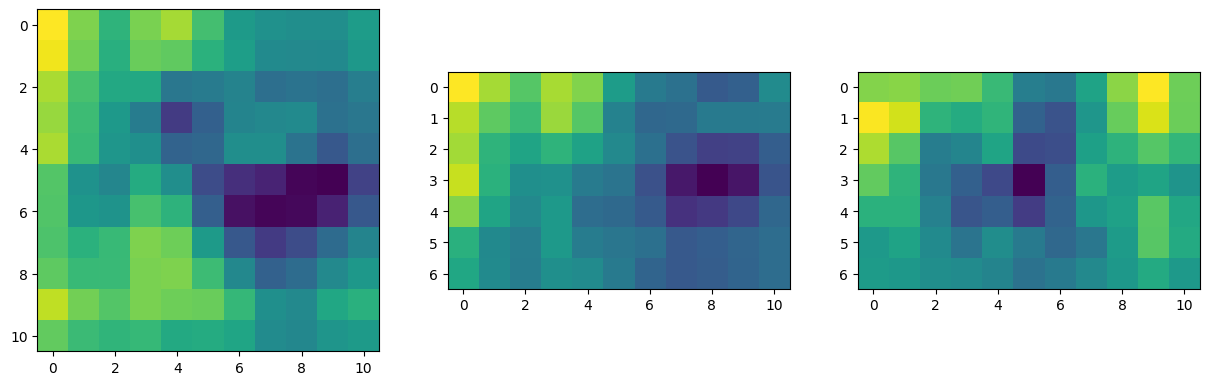

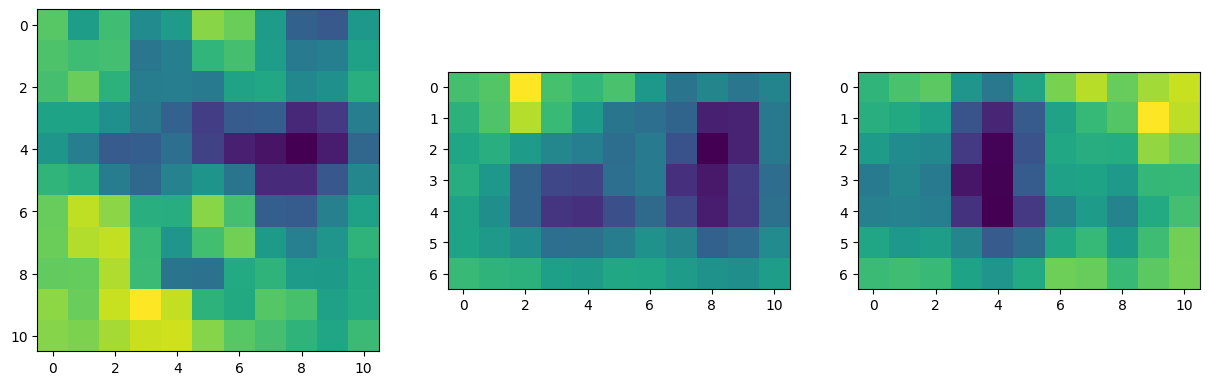

In [91]:
mask = model.rc(torch.ones(1, 1, *X[0].shape))
mask = mask.detach().numpy()
for i in range(mask.shape[1]):
    fig = plot_2d_projections(mask[0, i])
    plt.show()

In [92]:
@torch.no_grad()
def get_mask(shape, layer):
    convargs = ((shape[-3], shape[-2], shape[-1]), layer.kernel_size, layer.padding, layer.stride)
    out_tensor = torch.zeros(*shape, layer.out_channels)
    mask = torch.zeros(*shape, layer.out_channels)

    for n_neuron in range(layer.out_channels):
        for p, q, k in conviter(*convargs):
            w1_slice = layer.wave1[:, k[0], p[1], p[2], n_neuron]
            w2_slice = layer.wave2[:, p[0], k[1], p[2], n_neuron]
            w3_slice = layer.wave3[:, p[0], p[1], k[2], n_neuron]
            res = (w1_slice + w2_slice + w3_slice)
            out_tensor[:, p[-3], p[-2], p[-1], n_neuron] += res
            mask[:, p[-3], p[-2], p[-1], n_neuron] += 1
    mask[mask == 0] = 1
    return out_tensor/mask

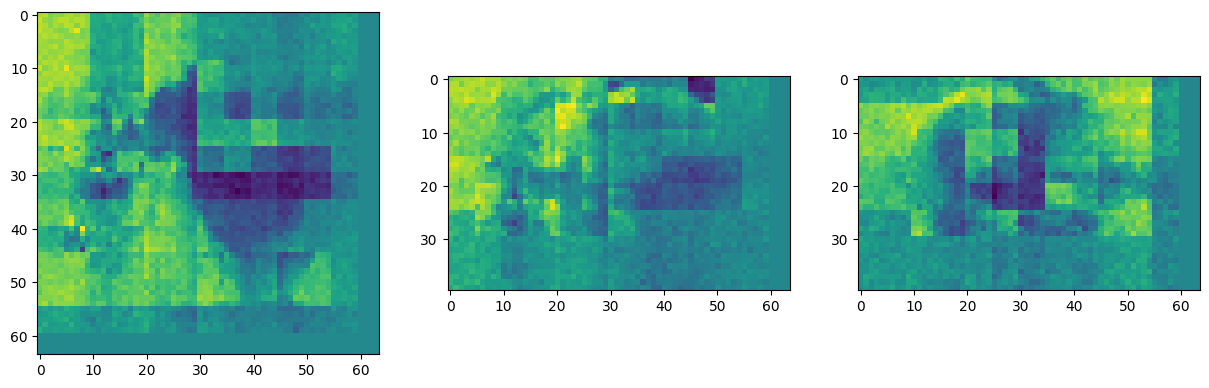

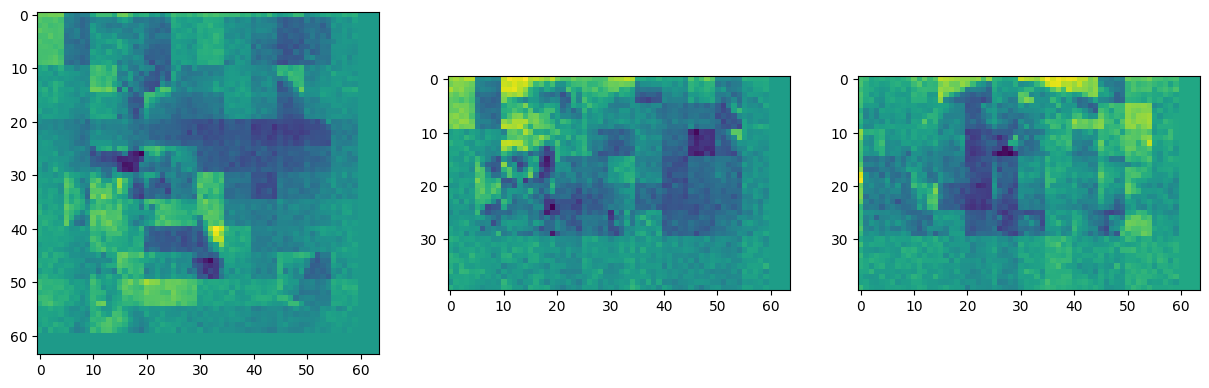

In [93]:
mask = torch.squeeze(get_mask(
    next(iter(DataLoader(test)))[0].shape, model.rc
))
if mask.ndim > 3:
    for i in range(mask.shape[-1]):
        fig = plot_2d_projections(mask.detach()[:, :, :, i])
        plt.show()
else:
    fig = plot_2d_projections(mask.detach()[:, :, :])
    plt.show()

In [209]:
ni_img_orig.affine

array([[   2.01900005,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    2.01900005,    0.        , -132.5       ],
       [   0.        ,    0.        ,    2.        ,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

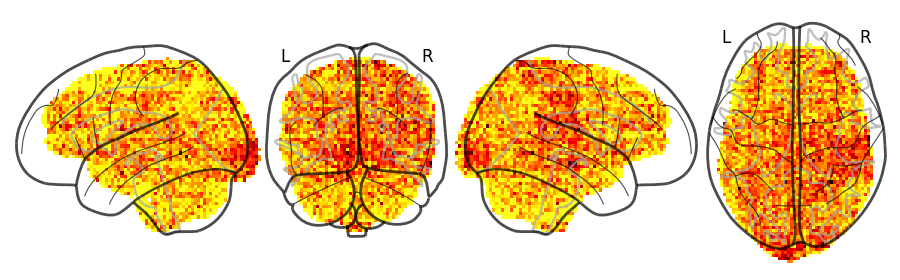

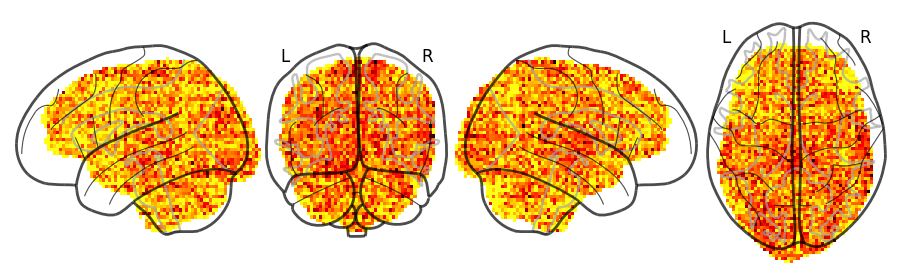

In [237]:
import nilearn.plotting as nip
if mask.ndim > 3:
    for i in range(mask.shape[-1]):
        mask_i = zscore(mask.detach()[:, :, :, i].numpy().copy())
        mask_i[mask_i<0] = -1
        ni_img = nb.Nifti1Image(
            np.pad(mask_i, pad_widths, mode='constant')*brainmap,
            ni_img_orig.affine
        )
        fig = nip.plot_glass_brain(ni_img, display_mode='lyrz')
        plt.show()
else:
    mask_i = zscore(mask.detach()[:, :, :].numpy().copy())
    mask_i[mask_i<0] = -1
    ni_img = nb.Nifti1Image(
        np.pad(mask_i, pad_widths, mode='constant')*brainmap,
        ni_img_orig.affine
    )
    fig = nip.plot_glass_brain(ni_img, display_mode='lyrz')
    plt.show()

In [ ]:
CC2t

In [72]:
class CC2t(BaseModel):
    def __init__(
        self,
        in_channels,
        out_channels,
        out_channels2,
        input_size,
        kernel_size,
        kernel_size2,
        n_classes: int,
        stride=1,
        stride2=1,
        padding=0,
        padding2=0,
        dropout=None,
        dropout2=None,
        batchnorm=False
    ):
        super().__init__()
        self.n_classes = n_classes
        self.rc = ResConv3D(in_channels, out_channels, input_size, kernel_size, stride, padding)
        self.dp = None if dropout is None else nn.Dropout(dropout)
        self.dp2 = None if dropout2 is None else nn.Dropout(dropout2)
        self.bn = nn.BatchNorm3d(out_channels) if batchnorm else None
        convargs = (input_size, kernel_size, padding, stride)
        self.convout_shape = compute_output_shape(*convargs)
        self.conv = nn.Conv3d(
            out_channels, out_channels2,
            kernel_size=kernel_size2,
            stride=stride2,
            padding=padding2
        )
        convargs = (self.convout_shape, kernel_size2, padding2, stride2)
        self.maxpool_shape = compute_output_shape(*convargs)
        self.num_features = out_channels*np.prod(self.maxpool_shape)
        self.linear = nn.Linear(self.num_features, self.n_classes)


    def forward(self, x: torch.Tensor):
        x = torch.unsqueeze(x, 1)
        # if self.bn:
        #     x = self.bn(x)
        x = self.rc(x)
        if self.dp:
            x = self.dp(x)
        if self.bn:
            x = self.bn(x)
        # x = self.relu(x)
        x = self.conv(x)
        # if self.bn:
        #     x = self.bn(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

In [101]:
model = CC2t(
    in_channels=1,
    out_channels=2,
    out_channels2=2,
    input_size=X[0].shape,
    kernel_size=(10, 10, 10),
    kernel_size2=(5, 5, 5),
    n_classes=Y.shape[-1],
    stride=5,
    stride2=5,
    dropout=.4,
    batchnorm=False
)

optimizer = torch.optim.Adam#W(model.parameters(), lr=1e-3)
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        L2Reg(
            [
                'rc.wave1', 'rc.wave2', 'rc.wave3',
            ],
            0.01
        ),
        EarlyStopping(monitor='loss_val', restore_best_weights=True, patience=10)
    ]
)

In [79]:
model.convout_shape, model.maxpool_shape, model.num_features

((7, 11, 11), (1, 2, 2), 8)

In [102]:
model(next(iter(DataLoader(train)))[0])

tensor([[ 0.1802, -0.2812, -0.1640,  0.1890,  0.2427, -0.0331, -0.2125, -0.1898,
         -0.2457]], grad_fn=<AddmmBackward0>)

In [103]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [104]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

Epoch 0:  loss_train:  0.4868   |    accuracy_train:  0.1675   |    loss_val:  0.4013   |    accuracy_val:  0.4394
Epoch 1:  loss_train:  0.4424   |    accuracy_train:  0.3766   |    loss_val:  0.3784   |    accuracy_val:  0.4394
Epoch 2:  loss_train:  0.4088   |    accuracy_train:  0.3444   |    loss_val:  0.3398   |    accuracy_val:  0.4394
Epoch 3:  loss_train:  0.3638   |    accuracy_train:  0.3580   |    loss_val:  0.3360   |    accuracy_val:  0.4394
Epoch 4:  loss_train:  0.3609   |    accuracy_train:  0.3496   |    loss_val:  0.3373   |    accuracy_val:  0.4394
Epoch 5:  loss_train:  0.3546   |    accuracy_train:  0.3662   |    loss_val:  0.3315   |    accuracy_val:  0.4394
Epoch 6:  loss_train:  0.3521   |    accuracy_train:  0.3764   |    loss_val:  0.3310   |    accuracy_val:  0.4394
  5%|▍         | 7/150 [02:02<41:51, 17.57s/it]


KeyboardInterrupt: 

In [83]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3357743133198131
train_accuracy: 0.3971968618306247
loss: 0.3271696757186543
accuracy: 0.4435518004677512


In [160]:
next(iter(DataLoader(test)))[0].shape

torch.Size([1, 79, 93, 71])

In [133]:
mask.shape

torch.Size([79, 93, 71])

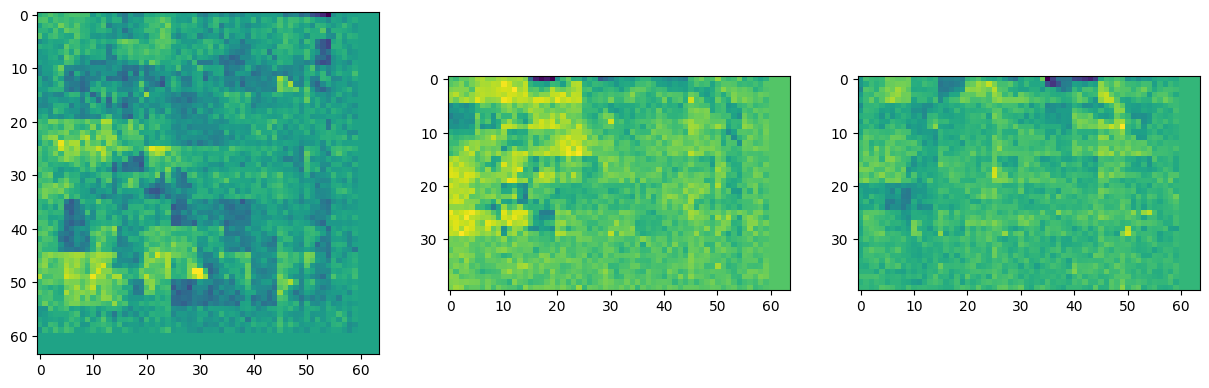

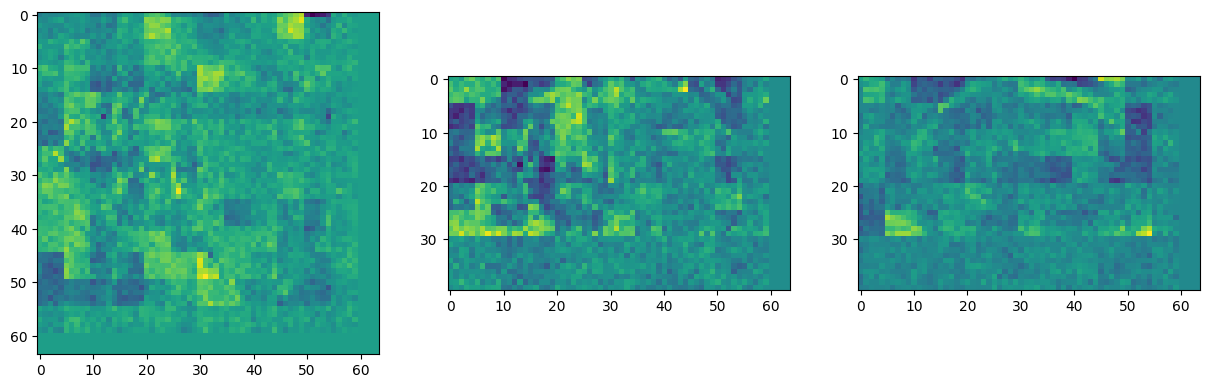

In [84]:
mask = torch.squeeze(get_mask(
    next(iter(DataLoader(test)))[0].shape, model.rc
))

for i in range(mask.shape[-1]):
    fig = plot_2d_projections(mask.detach()[:, :, :, i])
    plt.show()

In [539]:
model.convout_shape

(25, 34, 25)

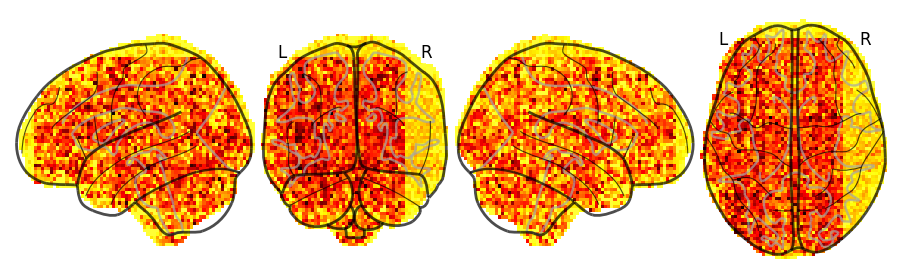

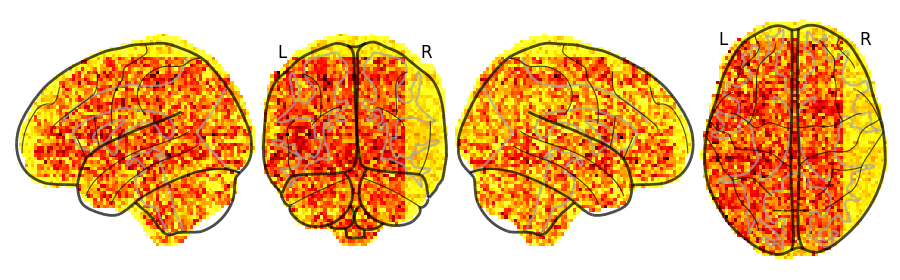

In [163]:
import nilearn.plotting as nip
for i in range(mask.shape[-1]):
    mask_i = zscore(mask.detach()[:, :, :, i].numpy().copy())
    mask_i[mask_i<0] = -1
    ni_img = nb.Nifti1Image(
        np.pad(mask_i, pad_widths, mode='constant')*brainmap,
        ni_img_orig.affine
    )
    fig = nip.plot_glass_brain(ni_img, display_mode='lyrz')
    plt.show()

In [13]:
class CC2r(BaseModel):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        maxpool_size,
        n_classes: int,
        dropout=None,
        n_steps = 2
    ):
        padding = 'same'
        self.n_steps = n_steps
        super().__init__()
        self.n_classes = n_classes
        self.rc = ResConv3D(in_channels, out_channels, input_size, kernel_size, padding=padding)
        self.dp = None if dropout is None else nn.Dropout(dropout)
        self.relu = nn.ReLU()
        convargs = (input_size, kernel_size, padding)
        self.convout_shape = compute_output_shape(*convargs)
        self.maxpool = nn.MaxPool3d((maxpool_size, maxpool_size, maxpool_size), maxpool_size)
        convargs = (self.convout_shape, (maxpool_size, maxpool_size, maxpool_size), 0, maxpool_size)
        self.maxpool_shape = compute_output_shape(*convargs)
        self.num_features = out_channels*np.prod(self.maxpool_shape)
        self.linear = nn.Linear(self.num_features, self.n_classes)


    def forward(self, x: torch.Tensor):
        x = torch.unsqueeze(x, 1)
        for i in range(self.n_steps):
            x = self.rc(x)
            if self.dp:
                x = self.dp(x)
        # x = self.relu(x)
        x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

In [14]:
model = CC2r(
    in_channels=1,
    out_channels=1,
    input_size=X[0].shape,
    kernel_size=(10, 10, 10),
    maxpool_size=5,
    n_classes=2,
    dropout=.4
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        L2Reg(
            [
                'rc.wave1', 'rc.wave2', 'rc.wave3',
            ],
            0.01
        ),
        EarlyStopping(monitor='loss_val', restore_best_weights=True, patience=10)
    ]
)

In [15]:
X[0].shape, model.convout_shape, model.maxpool_shape, model.num_features

(torch.Size([34, 43, 34]), (34, 43, 34), (6, 8, 6), 288)

In [52]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

In [17]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

Epoch 0:  loss_train:  0.7019   |    binary_accuracy_train:  0.5586   |    loss_val:  0.7240   |    binary_accuracy_val:  0.5603
Epoch 1:  loss_train:  0.6206   |    binary_accuracy_train:  0.6740   |    loss_val:  0.7072   |    binary_accuracy_val:  0.5794
Epoch 2:  loss_train:  0.5032   |    binary_accuracy_train:  0.8205   |    loss_val:  0.6542   |    binary_accuracy_val:  0.6275
Epoch 3:  loss_train:  0.3719   |    binary_accuracy_train:  0.8988   |    loss_val:  0.6279   |    binary_accuracy_val:  0.6860
Epoch 4:  loss_train:  0.2550   |    binary_accuracy_train:  0.9353   |    loss_val:  0.5565   |    binary_accuracy_val:  0.7426
Epoch 5:  loss_train:  0.1687   |    binary_accuracy_train:  0.9650   |    loss_val:  0.5680   |    binary_accuracy_val:  0.7321
  4%|▍         | 6/150 [56:24<22:33:42, 564.05s/it]


KeyboardInterrupt: 

In [18]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.25736006687987933
train_binary_accuracy: 0.9421487775715914
loss: 0.6576678563248027
binary_accuracy: 0.7142857150598005


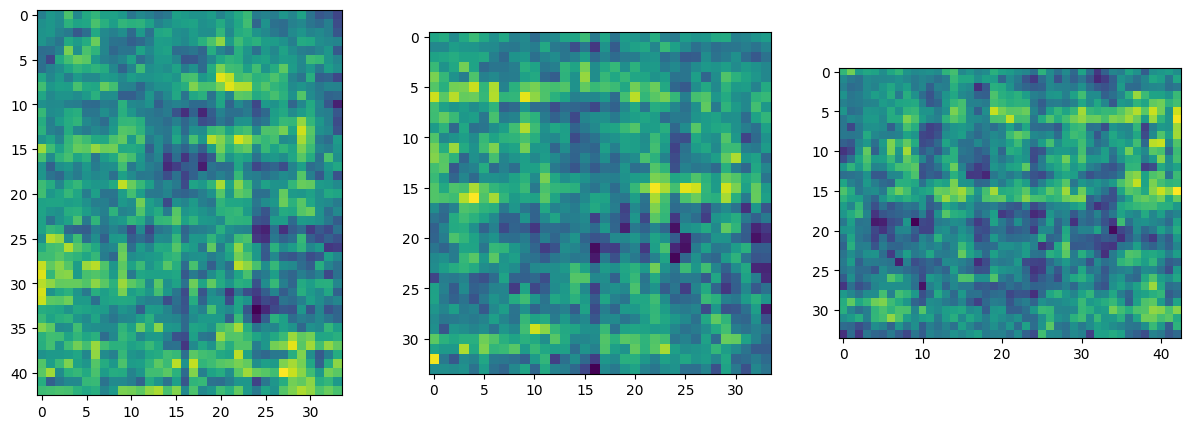

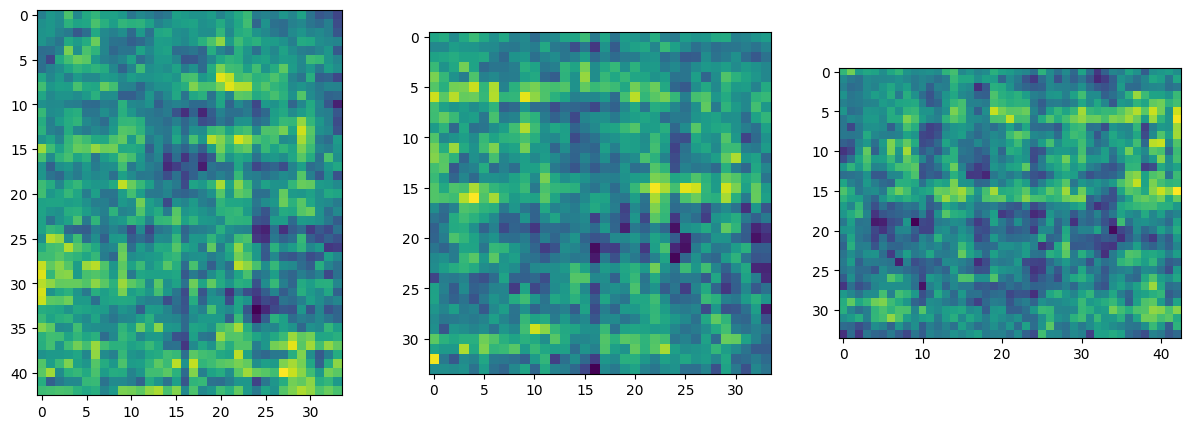

In [21]:
mask = torch.squeeze(get_mask(
    torch.squeeze(next(iter(DataLoader(test)))[0]).shape, model.rc
))
# for i in range(mask.shape[-1]):
fig = plot_2d_projections(mask.detach()[:, :, :])
plt.show()
mask = torch.squeeze(get_mask(
    torch.squeeze(next(iter(DataLoader(test)))[0]).shape, model.rc
))
# for i in range(mask.shape[-1]):
fig = plot_2d_projections(mask.detach()[:, :, :])
plt.show()